# COVID-19 Vaccinations by County

## Data Understanding

A full explanation of the different column names can be found [here](https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh/about_data). Below, we include some of the more important labels.

* [MMWR Week](https://ndc.services.cdc.gov/wp-content/uploads/MMWR_Week_overview.pdf), under `MMWR_week`, refers to the epidemiological ordering of weeks of the year, starting on Sunday and going until Saturday. These weeks are generally numbered 1-52.
* `Completeness_pct` corresponds to "the proportion of people with a completed primary series whose Federal Information Processing Standards (FIPS) code is reported and matches a valid county FIPS code in the jurisdiction."
    * Someone has completed their **primary series** if they have received a "second dose of a two-dose vaccine or one dose of a single-dose vaccine."
* There are then a number of different age brackets: the total number and percentage of individuals vaccinated who are above the ages of 5, 12, 18, and 64. So, for example, we have `Administered_Dose1_Recip`; the percentage form of that, `Administered_Dose1_Pop_Pct`; the raw numbers of those over 5 years old, `Administered_Dose1_Recip_5Plus`, and so on.
* `Booster_Doses` indicates the number of individuals who have completed a primary series and received a booster dose.

* `SVI` refers to the [social vulnerability index](https://www.atsdr.cdc.gov/placeandhealth/svi/index.html).
* `Metro_status` tells us whether someone lives within a metro area. We have a number of columns normalizing our data against both SVI and metro status.
* `Census2019` and associated columns bring over data from the 2019 census.
* We also have data about those receiving the bivalent booster (authorized by the FDA [late summer 2022](https://www.fda.gov/news-events/press-announcements/coronavirus-covid-19-update-fda-authorizes-moderna-pfizer-biontech-bivalent-covid-19-vaccines-use)), although this data only appears in age-binned categories.


---

Other useful information and links
* [FIPS codes](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html#ti1187912100)

In [856]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


deaths = pd.read_csv('../data/Provisional_COVID-19_Deaths_by_County__and_Race_and_Hispanic_Origin_20240102.csv')
vaccinations = pd.read_csv('../data/COVID-19_Vaccinations_by_County.csv')
election = pd.read_csv('../data/2020_US_County_Level_Presidential_Results.csv')

population = pd.read_excel('../data/PopulationEstimates.xlsx')
education = pd.read_excel('../data/Education.xlsx')
unemployment = pd.read_excel('../data/Unemployment.xlsx')
poverty = pd.read_excel('../data/PovertyEstimates.xlsx')

census_race = pd.read_csv('../data/cc-est2022-all.csv', encoding="latin-1")
census_age = pd.read_csv('../data/cc-est2022-agesex-all.csv')
CT_race = pd.read_excel('../data/CT_County_Race2019.xlsx')

/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_76802/4128310008.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  vaccinations = pd.read_csv('../data/COVID-19_Vaccinations_by_County.csv')


In [857]:
vaccinations.groupby(by="Recip_State")["Recip_County"].value_counts()



Recip_State  Recip_County              
AK           Aleutians East Borough        598
             Aleutians West Census Area    598
             Yakutat City and Borough      598
             Yukon-Koyukuk Census Area     598
             Wrangell City and Borough     598
                                          ... 
WY           Teton County                  598
             Uinta County                  598
             Washakie County               598
             Weston County                 598
             Unknown County                595
Name: count, Length: 3284, dtype: int64

In [858]:
vaccinations["Recip_State"].value_counts().__len__()

60

In [859]:
vaccinations["Recip_State"].value_counts()
# Removing PR (Puerto Rico), GU (Guam), and VI (Virgin Islands)
vaccinations = vaccinations[(vaccinations["Recip_State"] != "PR") & (vaccinations["Recip_State"] != "GU") & (vaccinations["Recip_State"] != "VI")]
vaccinations["Recip_State"].value_counts().__len__()

57

In [860]:
def drop_terrs(df, state):
    df = df[(df[state] != "PR") & (df[state] != "GU") & (df[state] != "VI") & (df[state] != "AK")]
    return df

def County_with_State(df, county, state):
    df["County_with_State"] = df[county] + ", " + df[state]

In [861]:
# Removing unknown counties
vaccinations = vaccinations[vaccinations["Recip_County"] != "Unknown County"]

County_with_State(vaccinations, "Recip_County", "Recip_State")
vaccinations["County_with_State"].value_counts()

# Leaves us with 3142 unique counties, each with 598 entries.

County_with_State
Washburn County, WI      598
Wheeler County, TX       598
Madison County, AL       598
Slope County, ND         598
Jefferson County, MS     598
                        ... 
Pasquotank County, NC    598
Chariton County, MO      598
Botetourt County, VA     598
Marion County, TN        598
Santa Rosa County, FL    598
Name: count, Length: 3142, dtype: int64

In [862]:
vaccinations

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Census2019_65PlusPop,Bivalent_Booster_5Plus,Bivalent_Booster_5Plus_Pop_Pct,Bivalent_Booster_12Plus,Bivalent_Booster_12Plus_Pop_Pct,Bivalent_Booster_18Plus,Bivalent_Booster_18Plus_Pop_Pct,Bivalent_Booster_65Plus,Bivalent_Booster_65Plus_Pop_Pct,County_with_State
0,05/10/2023,55129,19,Washburn County,WI,96.7,11123.0,70.8,11097.0,73.9,...,4304.0,3978.0,26.5,3955.0,28.6,3899.0,30.6,2588.0,60.1,"Washburn County, WI"
1,05/10/2023,19173,19,Taylor County,IA,97.3,3149.0,51.4,3145.0,55.0,...,1392.0,841.0,14.7,841.0,16.3,834.0,17.8,588.0,42.2,"Taylor County, IA"
2,05/10/2023,36059,19,Nassau County,NY,97.5,1391226.0,95.0,1384503.0,95.0,...,246690.0,236202.0,18.4,231748.0,19.8,224931.0,21.1,109947.0,44.6,"Nassau County, NY"
3,05/10/2023,48281,19,Lampasas County,TX,98.9,11678.0,54.5,11660.0,57.4,...,4322.0,1951.0,9.6,1947.0,10.5,1925.0,11.5,1229.0,28.4,"Lampasas County, TX"
4,05/10/2023,26145,19,Saginaw County,MI,94.0,104075.0,54.6,NaN,NaN,...,37414.0,15618.0,8.7,15448.0,9.4,15112.0,10.1,7921.0,21.2,"Saginaw County, MI"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962776,12/13/2020,39001,51,Adams County,OH,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Adams County, OH"
1962777,12/13/2020,18061,51,Harrison County,IN,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Harrison County, IN"
1962778,12/13/2020,48321,51,Matagorda County,TX,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Matagorda County, TX"
1962779,12/13/2020,54073,51,Pleasants County,WV,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Pleasants County, WV"


In [863]:
# Only using year-end dates for 2021 and 2022, and most recent available data for 2023.
# 05/10/2023; 12/28/2022; 12/31/2021

vaccinations = vaccinations[(vaccinations["Date"] == "05/10/2023") | (vaccinations["Date"] == "12/28/2022") | (vaccinations["Date"] == "12/31/2021")]
vaccinations
# And we're left with 9339 rows, corresponding to 3 entries per county.

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Census2019_65PlusPop,Bivalent_Booster_5Plus,Bivalent_Booster_5Plus_Pop_Pct,Bivalent_Booster_12Plus,Bivalent_Booster_12Plus_Pop_Pct,Bivalent_Booster_18Plus,Bivalent_Booster_18Plus_Pop_Pct,Bivalent_Booster_65Plus,Bivalent_Booster_65Plus_Pop_Pct,County_with_State
0,05/10/2023,55129,19,Washburn County,WI,96.7,11123.0,70.8,11097.0,73.9,...,4304.0,3978.0,26.5,3955.0,28.6,3899.0,30.6,2588.0,60.1,"Washburn County, WI"
1,05/10/2023,19173,19,Taylor County,IA,97.3,3149.0,51.4,3145.0,55.0,...,1392.0,841.0,14.7,841.0,16.3,834.0,17.8,588.0,42.2,"Taylor County, IA"
2,05/10/2023,36059,19,Nassau County,NY,97.5,1391226.0,95.0,1384503.0,95.0,...,246690.0,236202.0,18.4,231748.0,19.8,224931.0,21.1,109947.0,44.6,"Nassau County, NY"
3,05/10/2023,48281,19,Lampasas County,TX,98.9,11678.0,54.5,11660.0,57.4,...,4322.0,1951.0,9.6,1947.0,10.5,1925.0,11.5,1229.0,28.4,"Lampasas County, TX"
4,05/10/2023,26145,19,Saginaw County,MI,94.0,104075.0,54.6,NaN,NaN,...,37414.0,15618.0,8.7,15448.0,9.4,15112.0,10.1,7921.0,21.2,"Saginaw County, MI"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705910,12/31/2021,42029,52,Chester County,PA,94.6,489163.0,93.2,489120.0,95.0,...,88351.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Chester County, PA"
705911,12/31/2021,17001,52,Adams County,IL,98.0,36183.0,55.3,36179.0,59.0,...,13513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Adams County, IL"
705912,12/31/2021,48099,52,Coryell County,TX,99.1,39550.0,52.1,39526.0,55.8,...,8040.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Coryell County, TX"
705913,12/31/2021,18081,52,Johnson County,IN,98.6,100092.0,63.3,100086.0,67.5,...,23480.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Johnson County, IN"


In [864]:
saginaw_mi["Date"] = pd.to_datetime(saginaw_mi["Date"])
saginaw_mi.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 4 to 705356
Data columns (total 81 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Date                                     3 non-null      datetime64[ns]
 1   FIPS                                     3 non-null      object        
 2   MMWR_week                                3 non-null      int64         
 3   Recip_County                             3 non-null      object        
 4   Recip_State                              3 non-null      object        
 5   Completeness_pct                         3 non-null      float64       
 6   Administered_Dose1_Recip                 3 non-null      float64       
 7   Administered_Dose1_Pop_Pct               3 non-null      float64       
 8   Administered_Dose1_Recip_5Plus           1 non-null      float64       
 9   Administered_Dose1_Recip_5PlusPop_Pct    1 non-

/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_76802/1480338031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saginaw_mi["Date"] = pd.to_datetime(saginaw_mi["Date"])


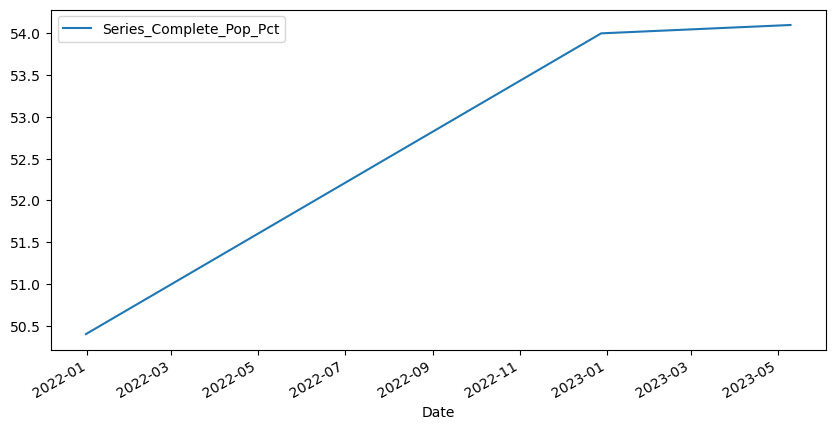

In [865]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = saginaw_mi.plot(x="Date", y="Series_Complete_Pop_Pct", ax=ax)

## Presidential Election Data

In [866]:
election.head()

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff
0,Alabama,1001,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623
2,Alabama,1005,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631
3,Alabama,1007,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280
4,Alabama,1009,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022


In [867]:
# adding a state_abbrev column
state_abbrevs = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

election["state_abbrev"] = election["state_name"].map(state_abbrevs)
election.head()

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,state_abbrev
0,Alabama,1001,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184,AL
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623,AL
2,Alabama,1005,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631,AL
3,Alabama,1007,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280,AL
4,Alabama,1009,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022,AL


In [868]:
election["state_name"].value_counts().__len__()

51

In [869]:
election.groupby(by="state_abbrev")["county_name"].value_counts()

state_abbrev  county_name    
AK            District 1         1
              District 10        1
              District 33        1
              District 34        1
              District 35        1
                                ..
WY            Teton County       1
              Uinta County       1
              Washakie County    1
              Albany County      1
              Weston County      1
Name: count, Length: 3152, dtype: int64

In [870]:
election

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,state_abbrev
0,Alabama,1001,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184,AL
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623,AL
2,Alabama,1005,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631,AL
3,Alabama,1007,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280,AL
4,Alabama,1009,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022,AL
...,...,...,...,...,...,...,...,...,...,...,...
3147,Wyoming,56037,Sweetwater County,12229,3823,16603,8406,0.736554,0.230260,0.506294,WY
3148,Wyoming,56039,Teton County,4341,9848,14677,-5507,0.295769,0.670982,-0.375213,WY
3149,Wyoming,56041,Uinta County,7496,1591,9402,5905,0.797277,0.169219,0.628058,WY
3150,Wyoming,56043,Washakie County,3245,651,4012,2594,0.808824,0.162263,0.646560,WY


In [871]:
election["votes_third_party"] = election["total_votes"] - election["votes_dem"] - election["votes_gop"]
election["per_third_party"] = election["votes_third_party"] / election["total_votes"]


In [872]:
# Dropping PR (Puerto Rico), GU (Guam), and VI (Virgin Islands)
# This doesn't actually change the total number of counties.
# election = election[(election["state_abbrev"] != "PR") & (election["state_abbrev"] != "GU") & (election["state_abbrev"] != "VI")]

County_with_State(election, "county_name", "state_abbrev")
election["County_with_State"].value_counts()

County_with_State
Autauga County, AL      1
Knox County, OH         1
Lawrence County, OH     1
Licking County, OH      1
Logan County, OH        1
                       ..
Hart County, KY         1
Henderson County, KY    1
Henry County, KY        1
Hickman County, KY      1
Weston County, WY       1
Name: count, Length: 3152, dtype: int64

In [873]:
# Function to automatically compare difference in counties:
def check_overlap(df1, df2, column):
    vc1 = pd.DataFrame(df1[column])
    vc2 = pd.DataFrame(df2[column])
    combined = pd.merge(vc1, vc2, how="outer", indicator=True)
    combined_right = combined[combined["_merge"] == "right_only"]
    combined_left = combined[combined["_merge"] == "left_only"]
    return combined_right.value_counts(), combined_left.value_counts()

check_overlap(election, vaccinations, "County_with_State")

(County_with_State                      _merge    
 Aleutians East Borough, AK             right_only    3
 Aleutians West Census Area, AK         right_only    3
 Yakutat City and Borough, AK           right_only    3
 Wrangell City and Borough, AK          right_only    3
 Valdez-Cordova Census Area, AK         right_only    3
 Southeast Fairbanks Census Area, AK    right_only    3
 Skagway Municipality, AK               right_only    3
 Sitka City and Borough, AK             right_only    3
 Prince of Wales-Hyder Census Area, AK  right_only    3
 Petersburg Census Area, AK             right_only    3
 Northwest Arctic Borough, AK           right_only    3
 North Slope Borough, AK                right_only    3
 Nome Census Area, AK                   right_only    3
 Matanuska-Susitna Borough, AK          right_only    3
 Lake and Peninsula Borough, AK         right_only    3
 La Salle Parish, LA                    right_only    3
 Kusilvak Census Area, AK               right_only   

"Unlike other states within the United States, Alaska does not administer its presidential elections at the county-level but rather at the lower chamber legislative district, or the House District."[link](https://github.com/tonmcg/US_County_Level_Election_Results_08-20?tab=readme-ov-file#alaska)

In [874]:
# Removing Alaska from the dfs:
election = election[election["state_abbrev"] != "AK"]
vaccinations = vaccinations[vaccinations["Recip_State"] != "AK"]

# Comparing again:
check_overlap(election, vaccinations, "County_with_State")

(County_with_State    _merge    
 Dona Ana County, NM  right_only    3
 Kalawao County, HI   right_only    3
 La Salle Parish, LA  right_only    3
 Name: count, dtype: int64,
 County_with_State    _merge   
 Doña Ana County, NM  left_only    1
 LaSalle Parish, LA   left_only    1
 Name: count, dtype: int64)

In [875]:
# Renaming the different county names to match
election["County_with_State"] = election["County_with_State"].replace("Doña Ana County, NM", "Dona Ana County, NM")
election["county_name"] = election["county_name"].replace("Doña Ana County", "Dona Ana County")
election["County_with_State"] = election["County_with_State"].replace("LaSalle Parish, LA", "La Salle Parish, LA")
election["county_name"] = election["county_name"].replace("LaSalle Parish", "La Salle Parish")

# Comparing again:
check_overlap(election, vaccinations, "County_with_State")



/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_76802/3583198658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election["County_with_State"] = election["County_with_State"].replace("Doña Ana County, NM", "Dona Ana County, NM")
/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_76802/3583198658.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election["county_name"] = election["county_name"].replace("Doña Ana County", "Dona Ana County")
/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000

(County_with_State   _merge    
 Kalawao County, HI  right_only    3
 Name: count, dtype: int64,
 Series([], Name: count, dtype: int64))

# Paring down and combining the dataframes

In [876]:
election = election[["per_gop", "per_dem", "per_third_party", "County_with_State"]]
election.loc[3152] = [0.0417, 0.9583, 0, "Kalawao County, HI"]
election

,per_gop,per_dem,per_third_party,County_with_State
0,0.714368,0.270184,0.015448,"Autauga County, AL"
1,0.761714,0.224090,0.014196,"Baldwin County, AL"
2,0.534512,0.457882,0.007606,"Barbour County, AL"
3,0.784263,0.206983,0.008755,"Bibb County, AL"
4,0.895716,0.095694,0.008591,"Blount County, AL"
...,...,...,...,...
3148,0.295769,0.670982,0.033249,"Teton County, WY"
3149,0.797277,0.169219,0.033504,"Uinta County, WY"
3150,0.808824,0.162263,0.028913,"Washakie County, WY"
3151,0.877188,0.101637,0.021174,"Weston County, WY"


In [877]:
vaccinations

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Census2019_65PlusPop,Bivalent_Booster_5Plus,Bivalent_Booster_5Plus_Pop_Pct,Bivalent_Booster_12Plus,Bivalent_Booster_12Plus_Pop_Pct,Bivalent_Booster_18Plus,Bivalent_Booster_18Plus_Pop_Pct,Bivalent_Booster_65Plus,Bivalent_Booster_65Plus_Pop_Pct,County_with_State
0,05/10/2023,55129,19,Washburn County,WI,96.7,11123.0,70.8,11097.0,73.9,...,4304.0,3978.0,26.5,3955.0,28.6,3899.0,30.6,2588.0,60.1,"Washburn County, WI"
1,05/10/2023,19173,19,Taylor County,IA,97.3,3149.0,51.4,3145.0,55.0,...,1392.0,841.0,14.7,841.0,16.3,834.0,17.8,588.0,42.2,"Taylor County, IA"
2,05/10/2023,36059,19,Nassau County,NY,97.5,1391226.0,95.0,1384503.0,95.0,...,246690.0,236202.0,18.4,231748.0,19.8,224931.0,21.1,109947.0,44.6,"Nassau County, NY"
3,05/10/2023,48281,19,Lampasas County,TX,98.9,11678.0,54.5,11660.0,57.4,...,4322.0,1951.0,9.6,1947.0,10.5,1925.0,11.5,1229.0,28.4,"Lampasas County, TX"
4,05/10/2023,26145,19,Saginaw County,MI,94.0,104075.0,54.6,NaN,NaN,...,37414.0,15618.0,8.7,15448.0,9.4,15112.0,10.1,7921.0,21.2,"Saginaw County, MI"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705910,12/31/2021,42029,52,Chester County,PA,94.6,489163.0,93.2,489120.0,95.0,...,88351.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Chester County, PA"
705911,12/31/2021,17001,52,Adams County,IL,98.0,36183.0,55.3,36179.0,59.0,...,13513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Adams County, IL"
705912,12/31/2021,48099,52,Coryell County,TX,99.1,39550.0,52.1,39526.0,55.8,...,8040.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Coryell County, TX"
705913,12/31/2021,18081,52,Johnson County,IN,98.6,100092.0,63.3,100086.0,67.5,...,23480.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Johnson County, IN"


In [878]:
"""
Filter by 
* Date
* County_with_State
* Completeness_pct
* Series_Complete_18PlusPop_Pct
* Booster_Doses_Vax_Pct
* Booster_Doses_18Plus_Vax_Pct
* Metro_status
* SVI_CTGY
* Census2019
* Census2019_18PlusPop
"""

vaccinations = vaccinations[["Date", "County_with_State", "Completeness_pct", "Series_Complete_18PlusPop_Pct", "Booster_Doses_Vax_Pct", "Booster_Doses_18Plus_Vax_Pct", "Metro_status", "SVI_CTGY", "Census2019", "Census2019_18PlusPop"]]
vaccinations

,Date,County_with_State,Completeness_pct,Series_Complete_18PlusPop_Pct,Booster_Doses_Vax_Pct,Booster_Doses_18Plus_Vax_Pct,Metro_status,SVI_CTGY,Census2019,Census2019_18PlusPop
0,05/10/2023,"Washburn County, WI",96.7,75.7,65.9,68.3,Non-metro,A,15720.0,12758.0
1,05/10/2023,"Taylor County, IA",97.3,59.6,61.1,63.5,Non-metro,A,6121.0,4687.0
2,05/10/2023,"Nassau County, NY",97.5,95.0,46.5,49.4,Metro,B,1356924.0,1065968.0
3,05/10/2023,"Lampasas County, TX",98.9,55.5,42.1,44.4,Metro,C,21428.0,16799.0
4,05/10/2023,"Saginaw County, MI",94.0,64.0,56.9,59.3,Metro,C,190539.0,149676.0
...,...,...,...,...,...,...,...,...,...,...
705910,12/31/2021,"Chester County, PA",94.6,83.3,30.2,33.8,Metro,A,524989.0,407024.0
705911,12/31/2021,"Adams County, IL",98.0,62.1,36.8,38.8,Non-metro,A,65435.0,50674.0
705912,12/31/2021,"Coryell County, TX",99.1,54.3,24.4,26.0,Metro,D,75951.0,58799.0
705913,12/31/2021,"Johnson County, IN",98.6,67.7,33.9,36.6,Metro,A,158167.0,119315.0


In [879]:
# Making the combined df

df = pd.merge(election, vaccinations, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Completeness_pct,Series_Complete_18PlusPop_Pct,Booster_Doses_Vax_Pct,Booster_Doses_18Plus_Vax_Pct,Metro_status,SVI_CTGY,Census2019,Census2019_18PlusPop
0,0.714368,0.270184,0.015448,"Autauga County, AL",05/10/2023,92.6,54.3,38.0,40.4,Metro,C,55869.0,42904.0
1,0.714368,0.270184,0.015448,"Autauga County, AL",12/28/2022,92.6,54.1,37.6,40.0,Metro,C,55869.0,42904.0
2,0.714368,0.270184,0.015448,"Autauga County, AL",12/31/2021,92.7,46.8,25.8,27.6,Metro,B,55869.0,42904.0
3,0.761714,0.224090,0.014196,"Baldwin County, AL",05/10/2023,92.6,63.4,39.9,41.4,Metro,B,223234.0,175680.0
4,0.761714,0.224090,0.014196,"Baldwin County, AL",12/28/2022,92.6,63.2,39.4,41.0,Metro,B,223234.0,175680.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9334,0.877188,0.101637,0.021174,"Weston County, WY",12/28/2022,97.1,46.9,51.3,52.9,Non-metro,A,6927.0,5512.0
9335,0.877188,0.101637,0.021174,"Weston County, WY",12/31/2021,96.5,42.1,39.6,40.8,Non-metro,B,6927.0,5512.0
9336,0.041700,0.958300,0.000000,"Kalawao County, HI",05/10/2023,NaN,NaN,NaN,NaN,Metro,A,86.0,86.0
9337,0.041700,0.958300,0.000000,"Kalawao County, HI",12/28/2022,NaN,NaN,NaN,NaN,Metro,A,86.0,86.0


# Poverty dataset

In [880]:
poverty = pd.read_excel('../data/PovertyEstimates.xlsx')
poverty.columns = poverty.iloc[3]
poverty

3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,CI90UB517P_2021,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021
0,"Source: U.S. Department of Commerce, Bureau of...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"For definitions of rural classifications, see ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"This table was prepared by USDA, Economic Rese...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,CI90UB517P_2021,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021
4,00000,US,United States,NaN,NaN,NaN,NaN,41393176,41149497,41636855,...,16.3,69717,69583,69851,3349149,3299669,3398629,18.3,18,18.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,56037,WY,Sweetwater County,5,8,5,8,3761,3048,4474,...,11.5,74677,66928,82426,NaN,NaN,NaN,NaN,NaN,NaN
3195,56039,WY,Teton County,7,8,7,8,1392,1070,1714,...,6.4,102709,90132,115286,NaN,NaN,NaN,NaN,NaN,NaN
3196,56041,WY,Uinta County,7,8,7,8,1917,1457,2377,...,12.9,70162,62206,78118,NaN,NaN,NaN,NaN,NaN,NaN
3197,56043,WY,Washakie County,7,11,7,11,773,579,967,...,15.6,62176,55415,68937,NaN,NaN,NaN,NaN,NaN,NaN


In [881]:
poverty.drop(poverty.index[0:5], inplace=True)
poverty = poverty[(poverty["Stabr"] != "PR") & (poverty["Stabr"] != "GU") & (poverty["Stabr"] != "VI") & (poverty["Stabr"] != "AK")]
poverty

3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,CI90UB517P_2021,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021
5,01000,AL,Alabama,NaN,NaN,NaN,NaN,800848,782169,819527,...,22.5,53990,53218,54762,71220,66888,75552,25.1,23.6,26.6
6,01001,AL,Autauga County,2,2,2,2,6296,4772,7820,...,20.4,66444,60061,72827,NaN,NaN,NaN,NaN,NaN,NaN
7,01003,AL,Baldwin County,4,5,3,2,25526,21599,29453,...,18.5,65658,60723,70593,NaN,NaN,NaN,NaN,NaN,NaN
8,01005,AL,Barbour County,6,6,6,6,5089,3773,6405,...,44.6,38649,34308,42990,NaN,NaN,NaN,NaN,NaN,NaN
9,01007,AL,Bibb County,1,1,1,1,4204,3324,5084,...,35.4,48454,42438,54470,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,56037,WY,Sweetwater County,5,8,5,8,3761,3048,4474,...,11.5,74677,66928,82426,NaN,NaN,NaN,NaN,NaN,NaN
3195,56039,WY,Teton County,7,8,7,8,1392,1070,1714,...,6.4,102709,90132,115286,NaN,NaN,NaN,NaN,NaN,NaN
3196,56041,WY,Uinta County,7,8,7,8,1917,1457,2377,...,12.9,70162,62206,78118,NaN,NaN,NaN,NaN,NaN,NaN
3197,56043,WY,Washakie County,7,11,7,11,773,579,967,...,15.6,62176,55415,68937,NaN,NaN,NaN,NaN,NaN,NaN


In [882]:
County_with_State(poverty, "Area_name", "Stabr")
poverty.head()

/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_76802/3100519213.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["County_with_State"] = df[county] + ", " + df[state]


3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021,County_with_State
5,01000,AL,Alabama,NaN,NaN,NaN,NaN,800848,782169,819527,...,53990,53218,54762,71220,66888,75552,25.1,23.6,26.6,"Alabama, AL"
6,01001,AL,Autauga County,2,2,2,2,6296,4772,7820,...,66444,60061,72827,NaN,NaN,NaN,NaN,NaN,NaN,"Autauga County, AL"
7,01003,AL,Baldwin County,4,5,3,2,25526,21599,29453,...,65658,60723,70593,NaN,NaN,NaN,NaN,NaN,NaN,"Baldwin County, AL"
8,01005,AL,Barbour County,6,6,6,6,5089,3773,6405,...,38649,34308,42990,NaN,NaN,NaN,NaN,NaN,NaN,"Barbour County, AL"
9,01007,AL,Bibb County,1,1,1,1,4204,3324,5084,...,48454,42438,54470,NaN,NaN,NaN,NaN,NaN,NaN,"Bibb County, AL"


In [883]:
check_overlap(df, poverty, "County_with_State")

(County_with_State    _merge    
 Alabama, AL          right_only    1
 Oregon, OR           right_only    1
 Montana, MT          right_only    1
 Nebraska, NE         right_only    1
 Nevada, NV           right_only    1
 New Hampshire, NH    right_only    1
 New Jersey, NJ       right_only    1
 New Mexico, NM       right_only    1
 New York, NY         right_only    1
 North Carolina, NC   right_only    1
 North Dakota, ND     right_only    1
 Ohio, OH             right_only    1
 Oklahoma, OK         right_only    1
 Pennsylvania, PA     right_only    1
 Mississippi, MS      right_only    1
 Rhode Island, RI     right_only    1
 South Carolina, SC   right_only    1
 South Dakota, SD     right_only    1
 Tennessee, TN        right_only    1
 Texas, TX            right_only    1
 Utah, UT             right_only    1
 Vermont, VT          right_only    1
 Virginia, VA         right_only    1
 Washington, WA       right_only    1
 West Virginia, WV    right_only    1
 Wisconsin, WI   

In [884]:
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
poverty.drop(poverty.index[poverty["Area_name"].isin(state_names)], inplace=True)
poverty

/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_76802/1263936022.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poverty.drop(poverty.index[poverty["Area_name"].isin(state_names)], inplace=True)


3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021,County_with_State
6,01001,AL,Autauga County,2,2,2,2,6296,4772,7820,...,66444,60061,72827,NaN,NaN,NaN,NaN,NaN,NaN,"Autauga County, AL"
7,01003,AL,Baldwin County,4,5,3,2,25526,21599,29453,...,65658,60723,70593,NaN,NaN,NaN,NaN,NaN,NaN,"Baldwin County, AL"
8,01005,AL,Barbour County,6,6,6,6,5089,3773,6405,...,38649,34308,42990,NaN,NaN,NaN,NaN,NaN,NaN,"Barbour County, AL"
9,01007,AL,Bibb County,1,1,1,1,4204,3324,5084,...,48454,42438,54470,NaN,NaN,NaN,NaN,NaN,NaN,"Bibb County, AL"
10,01009,AL,Blount County,1,1,1,1,6992,5516,8468,...,56894,52632,61156,NaN,NaN,NaN,NaN,NaN,NaN,"Blount County, AL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,56037,WY,Sweetwater County,5,8,5,8,3761,3048,4474,...,74677,66928,82426,NaN,NaN,NaN,NaN,NaN,NaN,"Sweetwater County, WY"
3195,56039,WY,Teton County,7,8,7,8,1392,1070,1714,...,102709,90132,115286,NaN,NaN,NaN,NaN,NaN,NaN,"Teton County, WY"
3196,56041,WY,Uinta County,7,8,7,8,1917,1457,2377,...,70162,62206,78118,NaN,NaN,NaN,NaN,NaN,NaN,"Uinta County, WY"
3197,56043,WY,Washakie County,7,11,7,11,773,579,967,...,62176,55415,68937,NaN,NaN,NaN,NaN,NaN,NaN,"Washakie County, WY"


In [885]:
"""
From poverty dataset, include:
* PCTPOVALL_2021, the overall percentage of people in poverty in 2021
* MEDHHINC_2021, the "[e]stimate of median household income 2021"
* County_with_State
"""

poverty = poverty[["PCTPOVALL_2021", "MEDHHINC_2021", "County_with_State"]]
poverty


3,PCTPOVALL_2021,MEDHHINC_2021,County_with_State
6,10.7,66444,"Autauga County, AL"
7,10.8,65658,"Baldwin County, AL"
8,23,38649,"Barbour County, AL"
9,20.6,48454,"Bibb County, AL"
10,12,56894,"Blount County, AL"
...,...,...,...
3194,9.2,74677,"Sweetwater County, WY"
3195,5.9,102709,"Teton County, WY"
3196,9.4,70162,"Uinta County, WY"
3197,10.2,62176,"Washakie County, WY"


In [886]:
check_overlap(df, poverty, "County_with_State")

(County_with_State    _merge    
 De Kalb County, IN   right_only    1
 DeBaca County, NM    right_only    1
 La Porte County, IN  right_only    1
 La Salle County, IL  right_only    1
 Lagrange County, IN  right_only    1
 Mc Kean County, PA   right_only    1
 Name: count, dtype: int64,
 County_with_State    _merge   
 De Baca County, NM   left_only    3
 DeKalb County, IN    left_only    3
 LaGrange County, IN  left_only    3
 LaPorte County, IN   left_only    3
 LaSalle County, IL   left_only    3
 McKean County, PA    left_only    3
 Name: count, dtype: int64)

In [887]:
poverty["County_with_State"] = poverty["County_with_State"].replace("De Kalb County, IN", "DeKalb County, IN")
poverty["County_with_State"] = poverty["County_with_State"].replace("DeBaca County, NM", "De Baca County, NM")
poverty["County_with_State"] = poverty["County_with_State"].replace("La Porte County, IN", "LaPorte County, IN")
poverty["County_with_State"] = poverty["County_with_State"].replace("La Salle County, IL", "LaSalle County, IL")
poverty["County_with_State"] = poverty["County_with_State"].replace("Lagrange County, IN", "LaGrange County, IN")
poverty["County_with_State"] = poverty["County_with_State"].replace("Mc Kean County, PA", "McKean County, PA")

check_overlap(df, poverty, "County_with_State")

/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_76802/4265406907.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poverty["County_with_State"] = poverty["County_with_State"].replace("De Kalb County, IN", "DeKalb County, IN")
/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_76802/4265406907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poverty["County_with_State"] = poverty["County_with_State"].replace("DeBaca County, NM", "De Baca County, NM")
/var/folders/gf/gqtw2hsd3xx5_9tt2z

(Series([], Name: count, dtype: int64), Series([], Name: count, dtype: int64))

In [888]:
poverty.drop_duplicates(subset="County_with_State", inplace=True)
poverty

/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_76802/1961882938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poverty.drop_duplicates(subset="County_with_State", inplace=True)


3,PCTPOVALL_2021,MEDHHINC_2021,County_with_State
6,10.7,66444,"Autauga County, AL"
7,10.8,65658,"Baldwin County, AL"
8,23,38649,"Barbour County, AL"
9,20.6,48454,"Bibb County, AL"
10,12,56894,"Blount County, AL"
...,...,...,...
3194,9.2,74677,"Sweetwater County, WY"
3195,5.9,102709,"Teton County, WY"
3196,9.4,70162,"Uinta County, WY"
3197,10.2,62176,"Washakie County, WY"


In [889]:
df = pd.merge(df, poverty, how="inner", on="County_with_State")

In [890]:
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Completeness_pct,Series_Complete_18PlusPop_Pct,Booster_Doses_Vax_Pct,Booster_Doses_18Plus_Vax_Pct,Metro_status,SVI_CTGY,Census2019,Census2019_18PlusPop,PCTPOVALL_2021,MEDHHINC_2021
0,0.714368,0.270184,0.015448,"Autauga County, AL",05/10/2023,92.6,54.3,38.0,40.4,Metro,C,55869.0,42904.0,10.7,66444
1,0.714368,0.270184,0.015448,"Autauga County, AL",12/28/2022,92.6,54.1,37.6,40.0,Metro,C,55869.0,42904.0,10.7,66444
2,0.714368,0.270184,0.015448,"Autauga County, AL",12/31/2021,92.7,46.8,25.8,27.6,Metro,B,55869.0,42904.0,10.7,66444
3,0.761714,0.224090,0.014196,"Baldwin County, AL",05/10/2023,92.6,63.4,39.9,41.4,Metro,B,223234.0,175680.0,10.8,65658
4,0.761714,0.224090,0.014196,"Baldwin County, AL",12/28/2022,92.6,63.2,39.4,41.0,Metro,B,223234.0,175680.0,10.8,65658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9334,0.877188,0.101637,0.021174,"Weston County, WY",12/28/2022,97.1,46.9,51.3,52.9,Non-metro,A,6927.0,5512.0,10.4,62509
9335,0.877188,0.101637,0.021174,"Weston County, WY",12/31/2021,96.5,42.1,39.6,40.8,Non-metro,B,6927.0,5512.0,10.4,62509
9336,0.041700,0.958300,0.000000,"Kalawao County, HI",05/10/2023,NaN,NaN,NaN,NaN,Metro,A,86.0,86.0,NaN,NaN
9337,0.041700,0.958300,0.000000,"Kalawao County, HI",12/28/2022,NaN,NaN,NaN,NaN,Metro,A,86.0,86.0,NaN,NaN


In [891]:
df[df["County_with_State"].str.endswith("CT")]["County_with_State"].value_counts()


County_with_State
Fairfield County, CT     3
Hartford County, CT      3
Litchfield County, CT    3
Middlesex County, CT     3
New Haven County, CT     3
New London County, CT    3
Tolland County, CT       3
Windham County, CT       3
Name: count, dtype: int64

# Deaths!

In [892]:
deaths = pd.read_csv('../data/Provisional_COVID-19_Deaths_by_County__and_Race_and_Hispanic_Origin_20240102.csv')
deaths

,Data as of,Start Date,End Date,State,County Name,Urban Rural Code,FIPS State,FIPS County,FIPS Code,Indicator,...,COVID-19 Deaths,Non-Hispanic White,Non-Hispanic Black,Non-Hispanic American Indian or Alaska Native,Non-Hispanic Asian,Non-Hispanic Native Hawaiian or Other Pacific Islander,Hispanic,Other,Urban Rural Description,Footnote
0,09/27/2023,01/01/2020,09/23/2023,AK,Anchorage Municipality,3,2,20,2020,Distribution of all-cause deaths (%),...,787,0.568,0.044,0.216,0.058,0.030,0.033,0.050,Medium metro,NaN
1,09/27/2023,01/01/2020,09/23/2023,AK,Anchorage Municipality,3,2,20,2020,Distribution of COVID-19 deaths (%),...,787,0.452,0.037,0.255,0.111,0.074,0.038,0.033,Medium metro,NaN
2,09/27/2023,01/01/2020,09/23/2023,AK,Anchorage Municipality,3,2,20,2020,Distribution of population (%),...,787,0.564,0.052,0.083,0.098,0.031,0.095,0.077,Medium metro,NaN
3,09/27/2023,01/01/2020,09/23/2023,AK,Fairbanks North Star Borough,4,2,90,2090,Distribution of all-cause deaths (%),...,214,0.710,0.024,0.173,0.020,NaN,0.027,0.044,Small metro,One or more data cells have counts between 1-9...
4,09/27/2023,01/01/2020,09/23/2023,AK,Fairbanks North Star Borough,4,2,90,2090,Distribution of COVID-19 deaths (%),...,214,0.626,NaN,0.257,NaN,NaN,NaN,0.056,Small metro,One or more data cells have counts between 1-9...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3682,09/27/2023,01/01/2020,09/23/2023,WY,Sheridan County,5,56,33,56033,Distribution of COVID-19 deaths (%),...,101,0.861,NaN,NaN,NaN,NaN,NaN,NaN,Micropolitan,One or more data cells have counts between 1-9...
3683,09/27/2023,01/01/2020,09/23/2023,WY,Sheridan County,5,56,33,56033,Distribution of population (%),...,101,0.913,0.007,0.011,0.008,0.001,0.047,0.014,Micropolitan,NaN
3684,09/27/2023,01/01/2020,09/23/2023,WY,Sweetwater County,5,56,37,56037,Distribution of all-cause deaths (%),...,115,0.885,0.013,0.009,NaN,NaN,0.083,NaN,Micropolitan,One or more data cells have counts between 1-9...
3685,09/27/2023,01/01/2020,09/23/2023,WY,Sweetwater County,5,56,37,56037,Distribution of COVID-19 deaths (%),...,115,0.887,NaN,NaN,NaN,NaN,0.096,NaN,Micropolitan,One or more data cells have counts between 1-9...


In [893]:
3687/3

1229.0

In [894]:
deaths["Indicator"].value_counts()

Indicator
Distribution of all-cause deaths (%)    1229
Distribution of COVID-19 deaths (%)     1229
Distribution of population (%)          1229
Name: count, dtype: int64

In [895]:
County_with_State(deaths, "County Name", "State")
deaths.head()

,Data as of,Start Date,End Date,State,County Name,Urban Rural Code,FIPS State,FIPS County,FIPS Code,Indicator,...,Non-Hispanic White,Non-Hispanic Black,Non-Hispanic American Indian or Alaska Native,Non-Hispanic Asian,Non-Hispanic Native Hawaiian or Other Pacific Islander,Hispanic,Other,Urban Rural Description,Footnote,County_with_State
0,09/27/2023,01/01/2020,09/23/2023,AK,Anchorage Municipality,3,2,20,2020,Distribution of all-cause deaths (%),...,0.568,0.044,0.216,0.058,0.030,0.033,0.050,Medium metro,NaN,"Anchorage Municipality, AK"
1,09/27/2023,01/01/2020,09/23/2023,AK,Anchorage Municipality,3,2,20,2020,Distribution of COVID-19 deaths (%),...,0.452,0.037,0.255,0.111,0.074,0.038,0.033,Medium metro,NaN,"Anchorage Municipality, AK"
2,09/27/2023,01/01/2020,09/23/2023,AK,Anchorage Municipality,3,2,20,2020,Distribution of population (%),...,0.564,0.052,0.083,0.098,0.031,0.095,0.077,Medium metro,NaN,"Anchorage Municipality, AK"
3,09/27/2023,01/01/2020,09/23/2023,AK,Fairbanks North Star Borough,4,2,90,2090,Distribution of all-cause deaths (%),...,0.710,0.024,0.173,0.020,NaN,0.027,0.044,Small metro,One or more data cells have counts between 1-9...,"Fairbanks North Star Borough, AK"
4,09/27/2023,01/01/2020,09/23/2023,AK,Fairbanks North Star Borough,4,2,90,2090,Distribution of COVID-19 deaths (%),...,0.626,NaN,0.257,NaN,NaN,NaN,0.056,Small metro,One or more data cells have counts between 1-9...,"Fairbanks North Star Borough, AK"


In [896]:
deaths = deaths[deaths["Indicator"] == "Distribution of COVID-19 deaths (%)"]
deaths

,Data as of,Start Date,End Date,State,County Name,Urban Rural Code,FIPS State,FIPS County,FIPS Code,Indicator,...,Non-Hispanic White,Non-Hispanic Black,Non-Hispanic American Indian or Alaska Native,Non-Hispanic Asian,Non-Hispanic Native Hawaiian or Other Pacific Islander,Hispanic,Other,Urban Rural Description,Footnote,County_with_State
1,09/27/2023,01/01/2020,09/23/2023,AK,Anchorage Municipality,3,2,20,2020,Distribution of COVID-19 deaths (%),...,0.452,0.037,0.255,0.111,0.074,0.038,0.033,Medium metro,NaN,"Anchorage Municipality, AK"
4,09/27/2023,01/01/2020,09/23/2023,AK,Fairbanks North Star Borough,4,2,90,2090,Distribution of COVID-19 deaths (%),...,0.626,NaN,0.257,NaN,NaN,NaN,0.056,Small metro,One or more data cells have counts between 1-9...,"Fairbanks North Star Borough, AK"
7,09/27/2023,01/01/2020,09/23/2023,AK,Matanuska-Susitna Borough,3,2,170,2170,Distribution of COVID-19 deaths (%),...,0.826,NaN,0.083,NaN,NaN,0.046,NaN,Medium metro,One or more data cells have counts between 1-9...,"Matanuska-Susitna Borough, AK"
10,09/27/2023,01/01/2020,09/23/2023,AL,Autauga County,3,1,1,1001,Distribution of COVID-19 deaths (%),...,0.761,0.218,NaN,NaN,NaN,NaN,NaN,Medium metro,One or more data cells have counts between 1-9...,"Autauga County, AL"
13,09/27/2023,01/01/2020,09/23/2023,AL,Baldwin County,4,1,3,1003,Distribution of COVID-19 deaths (%),...,0.884,0.086,NaN,NaN,NaN,0.023,NaN,Small metro,One or more data cells have counts between 1-9...,"Baldwin County, AL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3673,09/27/2023,01/01/2020,09/23/2023,WY,Laramie County,4,56,21,56021,Distribution of COVID-19 deaths (%),...,0.776,NaN,NaN,NaN,NaN,0.170,NaN,Small metro,One or more data cells have counts between 1-9...,"Laramie County, WY"
3676,09/27/2023,01/01/2020,09/23/2023,WY,Natrona County,4,56,25,56025,Distribution of COVID-19 deaths (%),...,0.824,NaN,0.088,NaN,NaN,0.069,NaN,Small metro,One or more data cells have counts between 1-9...,"Natrona County, WY"
3679,09/27/2023,01/01/2020,09/23/2023,WY,Park County,6,56,29,56029,Distribution of COVID-19 deaths (%),...,0.926,NaN,NaN,NaN,NaN,NaN,NaN,Noncore,One or more data cells have counts between 1-9...,"Park County, WY"
3682,09/27/2023,01/01/2020,09/23/2023,WY,Sheridan County,5,56,33,56033,Distribution of COVID-19 deaths (%),...,0.861,NaN,NaN,NaN,NaN,NaN,NaN,Micropolitan,One or more data cells have counts between 1-9...,"Sheridan County, WY"


In [897]:
check_overlap(df, deaths, "County_with_State")

(County_with_State                 _merge    
 Anchorage Municipality, AK        right_only    1
 Fairbanks North Star Borough, AK  right_only    1
 La Salle County, IL               right_only    1
 Matanuska-Susitna Borough, AK     right_only    1
 Name: count, dtype: int64,
 County_with_State          _merge   
 Abbeville County, SC       left_only    3
 Nicholas County, WV        left_only    3
 Norton city, VA            left_only    3
 Norton County, KS          left_only    3
 Northumberland County, VA  left_only    3
                                        ..
 Golden Valley County, MT   left_only    3
 Gogebic County, MI         left_only    3
 Glenn County, CA           left_only    3
 Glasscock County, TX       left_only    3
 Ziebach County, SD         left_only    3
 Name: count, Length: 1888, dtype: int64)

# Census & race

In [898]:
census_race = pd.read_csv('../data/cc-est2022-all.csv', encoding="latin-1")
census_race["state_abbrev"] = census_race["STNAME"].map(state_abbrevs)
County_with_State(census_race, "CTYNAME", "state_abbrev")
census_race

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,state_abbrev,County_with_State
0,50,1,1,Alabama,Autauga County,1,0,58802,28761,30041,...,112,97,40,30,22,24,19,11,AL,"Autauga County, AL"
1,50,1,1,Alabama,Autauga County,1,1,3443,1790,1653,...,14,9,3,1,9,1,3,1,AL,"Autauga County, AL"
2,50,1,1,Alabama,Autauga County,1,2,3613,1849,1764,...,5,8,7,3,0,1,1,2,AL,"Autauga County, AL"
3,50,1,1,Alabama,Autauga County,1,3,4131,2121,2010,...,10,10,1,3,2,2,2,1,AL,"Autauga County, AL"
4,50,1,1,Alabama,Autauga County,1,4,3963,2003,1960,...,8,9,5,2,2,4,3,2,AL,"Autauga County, AL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238939,50,56,45,Wyoming,Weston County,4,14,590,323,267,...,0,1,0,0,0,0,0,0,WY,"Weston County, WY"
238940,50,56,45,Wyoming,Weston County,4,15,415,231,184,...,0,0,0,0,0,0,0,0,WY,"Weston County, WY"
238941,50,56,45,Wyoming,Weston County,4,16,254,127,127,...,0,0,0,0,0,0,0,0,WY,"Weston County, WY"
238942,50,56,45,Wyoming,Weston County,4,17,141,71,70,...,0,0,1,0,0,0,0,0,WY,"Weston County, WY"


In [899]:
#def drop_terrs(df, state):
    #df = df.drop(df[(df[state] != "PR") & (df[state] != "GU") & (df[state] != "VI") & (df[state] != "AK")], inplace=True, axis=0)

def drop_terrs(df, state):
    df = df[(df[state] != "PR") & (df[state] != "GU") & (df[state] != "VI") & (df[state] != "AK")]
    return df




In [900]:
# Removing Alaska and other territories
census_race = drop_terrs(census_race, "state_abbrev")

# Also dropping CT because they changed from counties to different administrative districts
census_race = census_race[census_race["state_abbrev"] != "CT"]

Note: because CT stopped using counties in the census in 2022, we are going to use other data.
[wiki link](https://en.wikipedia.org/wiki/List_of_counties_in_Connecticut)

In [901]:
# Including all age groups
census_race = census_race[census_race["AGEGRP"] == 0]
# Using year 2022
census_race = census_race[census_race["YEAR"] == 4]

In [902]:
census_race["County_with_State"].value_counts()

County_with_State
Autauga County, AL      1
Van Wert County, OH     1
Morrow County, OH       1
Muskingum County, OH    1
Noble County, OH        1
                       ..
Menifee County, KY      1
Mercer County, KY       1
Metcalfe County, KY     1
Monroe County, KY       1
Weston County, WY       1
Name: count, Length: 3105, dtype: int64

In [903]:
census_race["WA"] = census_race["WA_MALE"] + census_race["WA_FEMALE"]
census_race["BA"] = census_race["BA_MALE"] + census_race["BA_FEMALE"]
census_race["IA"] = census_race["IA_MALE"] + census_race["IA_FEMALE"]
census_race["AAPI"] = census_race["AA_MALE"] + census_race["NA_MALE"] +  census_race["AA_FEMALE"] + census_race["NA_FEMALE"]
census_race.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,state_abbrev,County_with_State,WA,BA,IA,AAPI
57,50,1,1,Alabama,Autauga County,4,0,59759,29105,30654,...,23,22,22,19,AL,"Autauga County, AL",44697,12759,282,777
133,50,1,3,Alabama,Baldwin County,4,0,246435,120164,126271,...,118,132,88,86,AL,"Baldwin County, AL",215369,20759,1998,3013
209,50,1,5,Alabama,Barbour County,4,0,24706,13064,11642,...,10,9,33,18,AL,"Barbour County, AL",12149,11789,179,185
285,50,1,7,Alabama,Bibb County,4,0,22005,11775,10230,...,8,10,19,6,AL,"Bibb County, AL",16837,4623,126,93
361,50,1,9,Alabama,Blount County,4,0,59512,29583,29929,...,15,29,37,28,AL,"Blount County, AL",56768,1155,377,337


In [904]:
# link: https://portal.ct.gov/DPH/Health-Information-Systems--Reporting/Population/Annual-State-County-Population-with-Demographics-for-2000-2019
# dw about this lol
census_race = census_race[["WA", "BA", "IA", "AAPI", "County_with_State"]]
census_race.loc[238869] = [749569, 129086, 5810, 58867, "Fairfield County, CT"]
census_race.loc[238870] = [679325, 149165, 6027, 57203, "Hartford County, CT"]
census_race.loc[238871] = [170038, 5106, 775, 4414, "Litchfield County, CT"]
census_race.loc[238872] = [145937, 10011, 567, 5921, "Middlesex County, CT"]
census_race.loc[238873] = [670878, 138658, 5643, 39578, "New Haven County, CT"]
census_race.loc[238874] = [226391, 22194, 3820, 12801, "New London County, CT"]
census_race.loc[238875] = [135244, 6686, 511, 8280, "Tolland County, CT"]
census_race.loc[238876] = [109022, 4533, 1108, 2119, "Windham County, CT"]
census_race.tail(10)


,WA,BA,IA,AAPI,County_with_State
238849,7289,42,131,74,"Washakie County, WY"
238925,6369,57,145,105,"Weston County, WY"
238869,749569,129086,5810,58867,"Fairfield County, CT"
238870,679325,149165,6027,57203,"Hartford County, CT"
238871,170038,5106,775,4414,"Litchfield County, CT"
238872,145937,10011,567,5921,"Middlesex County, CT"
238873,670878,138658,5643,39578,"New Haven County, CT"
238874,226391,22194,3820,12801,"New London County, CT"
238875,135244,6686,511,8280,"Tolland County, CT"
238876,109022,4533,1108,2119,"Windham County, CT"


In [905]:
check_overlap(df, census_race, "County_with_State")

(County_with_State    _merge    
 Doña Ana County, NM  right_only    1
 LaSalle Parish, LA   right_only    1
 Name: count, dtype: int64,
 County_with_State    _merge   
 Dona Ana County, NM  left_only    3
 La Salle Parish, LA  left_only    3
 Name: count, dtype: int64)

In [906]:
census_race["County_with_State"] = census_race["County_with_State"].replace("Doña Ana County, NM", "Dona Ana County, NM")
census_race["County_with_State"] = census_race["County_with_State"].replace("LaSalle Parish, LA", "La Salle Parish, LA")

df = pd.merge(df, census_race, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Completeness_pct,Series_Complete_18PlusPop_Pct,Booster_Doses_Vax_Pct,Booster_Doses_18Plus_Vax_Pct,Metro_status,SVI_CTGY,Census2019,Census2019_18PlusPop,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI
0,0.714368,0.270184,0.015448,"Autauga County, AL",05/10/2023,92.6,54.3,38.0,40.4,Metro,C,55869.0,42904.0,10.7,66444,44697,12759,282,777
1,0.714368,0.270184,0.015448,"Autauga County, AL",12/28/2022,92.6,54.1,37.6,40.0,Metro,C,55869.0,42904.0,10.7,66444,44697,12759,282,777
2,0.714368,0.270184,0.015448,"Autauga County, AL",12/31/2021,92.7,46.8,25.8,27.6,Metro,B,55869.0,42904.0,10.7,66444,44697,12759,282,777
3,0.761714,0.224090,0.014196,"Baldwin County, AL",05/10/2023,92.6,63.4,39.9,41.4,Metro,B,223234.0,175680.0,10.8,65658,215369,20759,1998,3013
4,0.761714,0.224090,0.014196,"Baldwin County, AL",12/28/2022,92.6,63.2,39.4,41.0,Metro,B,223234.0,175680.0,10.8,65658,215369,20759,1998,3013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9334,0.877188,0.101637,0.021174,"Weston County, WY",12/28/2022,97.1,46.9,51.3,52.9,Non-metro,A,6927.0,5512.0,10.4,62509,6369,57,145,105
9335,0.877188,0.101637,0.021174,"Weston County, WY",12/31/2021,96.5,42.1,39.6,40.8,Non-metro,B,6927.0,5512.0,10.4,62509,6369,57,145,105
9336,0.041700,0.958300,0.000000,"Kalawao County, HI",05/10/2023,NaN,NaN,NaN,NaN,Metro,A,86.0,86.0,NaN,NaN,28,0,0,42
9337,0.041700,0.958300,0.000000,"Kalawao County, HI",12/28/2022,NaN,NaN,NaN,NaN,Metro,A,86.0,86.0,NaN,NaN,28,0,0,42


# Census & age

CT median age: 40.9 [census link](https://data.census.gov/profile/Connecticut?g=040XX00US09)

In [907]:
census_age = pd.read_csv('../data/cc-est2022-agesex-all.csv')
census_age["state_abbrev"] = census_age["STNAME"].map(state_abbrevs)
County_with_State(census_age, "CTYNAME", "state_abbrev")
census_age = drop_terrs(census_age, "state_abbrev")
census_age = census_age[census_age["state_abbrev"] != "CT"]
census_age = census_age[census_age["YEAR"] == 4]
census_age = census_age[["MEDIAN_AGE_TOT", "County_with_State"]]
census_age

,MEDIAN_AGE_TOT,County_with_State
3,39.2,"Autauga County, AL"
7,44.1,"Baldwin County, AL"
11,41.5,"Barbour County, AL"
15,40.9,"Bibb County, AL"
19,41.2,"Blount County, AL"
...,...,...
12559,37.7,"Sweetwater County, WY"
12563,41.0,"Teton County, WY"
12567,38.0,"Uinta County, WY"
12571,44.8,"Washakie County, WY"


In [908]:
# Imputing median CT age per county -- https://data.census.gov/profile/Connecticut?g=040XX00US09
census_age.loc[12576] = [40.9, "Fairfield County, CT"]
census_age.loc[12577] = [40.9, "Hartford County, CT"]
census_age.loc[12578] = [40.9, "Litchfield County, CT"]
census_age.loc[12579] = [40.9, "Middlesex County, CT"]
census_age.loc[12580] = [40.9, "New Haven County, CT"]
census_age.loc[12581] = [40.9, "New London County, CT"]
census_age.loc[12582] = [40.9, "Tolland County, CT"]
census_age.loc[12583] = [40.9, "Windham County, CT"]

census_age.tail(10)

,MEDIAN_AGE_TOT,County_with_State
12571,44.8,"Washakie County, WY"
12575,44.5,"Weston County, WY"
12576,40.9,"Fairfield County, CT"
12577,40.9,"Hartford County, CT"
12578,40.9,"Litchfield County, CT"
12579,40.9,"Middlesex County, CT"
12580,40.9,"New Haven County, CT"
12581,40.9,"New London County, CT"
12582,40.9,"Tolland County, CT"
12583,40.9,"Windham County, CT"


In [909]:
census_age.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3113 entries, 3 to 12583
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEDIAN_AGE_TOT     3113 non-null   float64
 1   County_with_State  3113 non-null   object 
dtypes: float64(1), object(1)
memory usage: 73.0+ KB


In [910]:
check_overlap(df, census_age, "County_with_State")

(County_with_State    _merge    
 Doña Ana County, NM  right_only    1
 LaSalle Parish, LA   right_only    1
 Name: count, dtype: int64,
 County_with_State    _merge   
 Dona Ana County, NM  left_only    3
 La Salle Parish, LA  left_only    3
 Name: count, dtype: int64)

In [911]:
census_age["County_with_State"] = census_age["County_with_State"].replace("Doña Ana County, NM", "Dona Ana County, NM")
census_age["County_with_State"] = census_age["County_with_State"].replace("LaSalle Parish, LA", "La Salle Parish, LA")

In [912]:
df = pd.merge(df, census_age, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Completeness_pct,Series_Complete_18PlusPop_Pct,Booster_Doses_Vax_Pct,Booster_Doses_18Plus_Vax_Pct,Metro_status,SVI_CTGY,Census2019,Census2019_18PlusPop,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT
0,0.714368,0.270184,0.015448,"Autauga County, AL",05/10/2023,92.6,54.3,38.0,40.4,Metro,C,55869.0,42904.0,10.7,66444,44697,12759,282,777,39.2
1,0.714368,0.270184,0.015448,"Autauga County, AL",12/28/2022,92.6,54.1,37.6,40.0,Metro,C,55869.0,42904.0,10.7,66444,44697,12759,282,777,39.2
2,0.714368,0.270184,0.015448,"Autauga County, AL",12/31/2021,92.7,46.8,25.8,27.6,Metro,B,55869.0,42904.0,10.7,66444,44697,12759,282,777,39.2
3,0.761714,0.224090,0.014196,"Baldwin County, AL",05/10/2023,92.6,63.4,39.9,41.4,Metro,B,223234.0,175680.0,10.8,65658,215369,20759,1998,3013,44.1
4,0.761714,0.224090,0.014196,"Baldwin County, AL",12/28/2022,92.6,63.2,39.4,41.0,Metro,B,223234.0,175680.0,10.8,65658,215369,20759,1998,3013,44.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9334,0.877188,0.101637,0.021174,"Weston County, WY",12/28/2022,97.1,46.9,51.3,52.9,Non-metro,A,6927.0,5512.0,10.4,62509,6369,57,145,105,44.5
9335,0.877188,0.101637,0.021174,"Weston County, WY",12/31/2021,96.5,42.1,39.6,40.8,Non-metro,B,6927.0,5512.0,10.4,62509,6369,57,145,105,44.5
9336,0.041700,0.958300,0.000000,"Kalawao County, HI",05/10/2023,NaN,NaN,NaN,NaN,Metro,A,86.0,86.0,NaN,NaN,28,0,0,42,56.3
9337,0.041700,0.958300,0.000000,"Kalawao County, HI",12/28/2022,NaN,NaN,NaN,NaN,Metro,A,86.0,86.0,NaN,NaN,28,0,0,42,56.3


# Education

In [913]:
 education = pd.read_excel('../data/Education.xlsx')
education.columns = education.iloc[2]
education.drop(education.index[0:4], inplace=True)
education.head()

2,Federal Information Processing Standard (FIPS) Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults completing some college or associate's degree, 2008-12","Percent of adults with a bachelor's degree or higher, 2008-12","Less than a high school diploma, 2017-21","High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21","Percent of adults with less than a high school diploma, 2017-21","Percent of adults with a high school diploma only, 2017-21","Percent of adults completing some college or associate's degree, 2017-21","Percent of adults with a bachelor's degree or higher, 2017-21"
4,01000,AL,Alabama,NaN,NaN,NaN,NaN,1062306,468269,136287,...,29.022866,22.264896,430047,1041209,1032122,910425,12.5973,30.499973,30.233789,26.668938
5,01001,AL,Autauga County,2,2,2,2,6611,3757,933,...,29.618142,21.707831,4126,12977,11367,11144,10.41551,32.758621,28.694401,28.131469
6,01003,AL,Baldwin County,4,5,3,2,18726,8426,2334,...,31.819503,27.741591,14555,44342,50518,52562,8.985844,27.375492,31.188379,32.450286
7,01005,AL,Barbour County,6,6,6,6,8120,2242,581,...,25.771784,14.524286,4378,6600,5010,2007,24.32898,36.676855,27.841067,11.153098
8,01007,AL,Bibb County,1,1,1,1,5272,1402,238,...,25.538085,8.996005,3125,7052,3967,1913,19.461917,43.91854,24.705736,11.913807


In [914]:
education.drop(education.index[education["Area name"].isin(state_names)], inplace=True)
education = drop_terrs(education, "State")
County_with_State(education, "Area name", "State")
education.head()

2,Federal Information Processing Standard (FIPS) Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults with a bachelor's degree or higher, 2008-12","Less than a high school diploma, 2017-21","High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21","Percent of adults with less than a high school diploma, 2017-21","Percent of adults with a high school diploma only, 2017-21","Percent of adults completing some college or associate's degree, 2017-21","Percent of adults with a bachelor's degree or higher, 2017-21",County_with_State
5,01001,AL,Autauga County,2,2,2,2,6611,3757,933,...,21.707831,4126,12977,11367,11144,10.41551,32.758621,28.694401,28.131469,"Autauga County, AL"
6,01003,AL,Baldwin County,4,5,3,2,18726,8426,2334,...,27.741591,14555,44342,50518,52562,8.985844,27.375492,31.188379,32.450286,"Baldwin County, AL"
7,01005,AL,Barbour County,6,6,6,6,8120,2242,581,...,14.524286,4378,6600,5010,2007,24.32898,36.676855,27.841067,11.153098,"Barbour County, AL"
8,01007,AL,Bibb County,1,1,1,1,5272,1402,238,...,8.996005,3125,7052,3967,1913,19.461917,43.91854,24.705736,11.913807,"Bibb County, AL"
9,01009,AL,Blount County,1,1,1,1,10677,3440,626,...,12.381469,6650,14284,13673,6061,16.351923,35.123439,33.621029,14.90361,"Blount County, AL"


In [921]:
education.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3118 entries, 5 to 3208
Data columns (total 56 columns):
 #   Column                                                                    Non-Null Count  Dtype 
---  ------                                                                    --------------  ----- 
 0   Federal Information Processing Standard (FIPS) Code                       3118 non-null   object
 1   State                                                                     3118 non-null   object
 2   Area name                                                                 3118 non-null   object
 3   2003 Rural-urban Continuum Code                                           3116 non-null   object
 4   2003 Urban Influence Code                                                 3116 non-null   object
 5   2013 Rural-urban Continuum Code                                           3114 non-null   object
 6   2013 Urban Influence Code                                                 311

In [915]:
check_overlap(df, education, "County_with_State")

(County_with_State              _merge    
 Bedford city, VA               right_only    1
 Clifton Forge city, VA         right_only    1
 La Salle County, IL            right_only    1
 Lousiana, LA                   right_only    1
 Yellowstone National Park, MT  right_only    1
 Name: count, dtype: int64,
 County_with_State   _merge   
 LaSalle County, IL  left_only    3
 Name: count, dtype: int64)

In [919]:
df[df["County_with_State"] == "Bedford City, VA"]

,per_gop,per_dem,per_third_party,County_with_State,Date,Completeness_pct,Series_Complete_18PlusPop_Pct,Booster_Doses_Vax_Pct,Booster_Doses_18Plus_Vax_Pct,Metro_status,SVI_CTGY,Census2019,Census2019_18PlusPop,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT


In [920]:
df[df["County_with_State"] == "Clifton Forge City, VA"]

,per_gop,per_dem,per_third_party,County_with_State,Date,Completeness_pct,Series_Complete_18PlusPop_Pct,Booster_Doses_Vax_Pct,Booster_Doses_18Plus_Vax_Pct,Metro_status,SVI_CTGY,Census2019,Census2019_18PlusPop,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT


In [926]:
education = education[(education["County_with_State"] != "Bedford city, VA") & (education["County_with_State"] != "Clifton Forge city, VA") & (education["County_with_State"] != "Lousiana, LA") & (education["County_with_State"] != "Yellowstone National Park, MT")]
education.replace("La Salle County, IL", "LaSalle County, IL", inplace=True)
education

2,Federal Information Processing Standard (FIPS) Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults with a bachelor's degree or higher, 2008-12","Less than a high school diploma, 2017-21","High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21","Percent of adults with less than a high school diploma, 2017-21","Percent of adults with a high school diploma only, 2017-21","Percent of adults completing some college or associate's degree, 2017-21","Percent of adults with a bachelor's degree or higher, 2017-21",County_with_State
5,01001,AL,Autauga County,2.0,2.0,2.0,2.0,6611.0,3757.0,933.0,...,21.707831,4126,12977,11367,11144,10.415510,32.758621,28.694401,28.131469,"Autauga County, AL"
6,01003,AL,Baldwin County,4.0,5.0,3.0,2.0,18726.0,8426.0,2334.0,...,27.741591,14555,44342,50518,52562,8.985844,27.375492,31.188379,32.450286,"Baldwin County, AL"
7,01005,AL,Barbour County,6.0,6.0,6.0,6.0,8120.0,2242.0,581.0,...,14.524286,4378,6600,5010,2007,24.328980,36.676855,27.841067,11.153098,"Barbour County, AL"
8,01007,AL,Bibb County,1.0,1.0,1.0,1.0,5272.0,1402.0,238.0,...,8.996005,3125,7052,3967,1913,19.461917,43.918540,24.705736,11.913807,"Bibb County, AL"
9,01009,AL,Blount County,1.0,1.0,1.0,1.0,10677.0,3440.0,626.0,...,12.381469,6650,14284,13673,6061,16.351923,35.123439,33.621029,14.903610,"Blount County, AL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204,56037,WY,Sweetwater County,5.0,8.0,5.0,8.0,4393.0,3731.0,986.0,...,17.006235,2029,9069,11324,5394,7.294363,32.603538,40.710383,19.391717,"Sweetwater County, WY"
3205,56039,WY,Teton County,7.0,8.0,7.0,8.0,708.0,908.0,524.0,...,48.994399,701,2984,3755,10219,3.969647,16.897899,21.263945,57.868509,"Teton County, WY"
3206,56041,WY,Uinta County,7.0,8.0,7.0,8.0,1569.0,1517.0,445.0,...,18.272985,851,4820,5186,2376,6.430892,36.424091,39.189904,17.955112,"Uinta County, WY"
3207,56043,WY,Washakie County,7.0,11.0,7.0,11.0,1572.0,1437.0,590.0,...,23.339826,320,1391,2293,1419,5.900793,25.650009,42.282869,26.166329,"Washakie County, WY"


In [927]:
check_overlap(df, education, "County_with_State")

(Series([], Name: count, dtype: int64), Series([], Name: count, dtype: int64))

# Extras

In [916]:
ct_data = pd.read_csv('../data/CT_data.csv', encoding="latin-1")
ct_data.head()

ParserError: Error tokenizing data. C error: Expected 1 fields in line 4, saw 2


In [ ]:
df1 = vaccinations[(vaccinations['FIPS'] == "UNK")]
#df1["Recip_State"].value_counts(normalize=True)
df1

KeyError: 'FIPS'

In [ ]:
vaccinations["Recip_County"].value_counts(normalize=True)

Recip_County
Washington County    0.009637
Jefferson County     0.008031
Franklin County      0.007710
Jackson County       0.007388
Lincoln County       0.007388
                       ...   
Conway County        0.000321
Pecos County         0.000321
Barnes County        0.000321
Gates County         0.000321
Santa Rosa County    0.000321
Name: proportion, Length: 1848, dtype: float64

In [ ]:



fips_counts = vaccinations["FIPS"].value_counts().reset_index()
fips_counts.drop(index=0, inplace=True)
fips_counts["FIPS"] = fips_counts['FIPS'].astype(int)
fips_counts.sort_values(by="FIPS", inplace=True)
fips_counts
#fips_counts.sort_values(by='FIPS')
#fips_counts..head()


#fips_counts.drop("UNK", axis=0, inplace=True)
#fips_counts = fips_counts.astype(int)
#fips_counts["FIPS"].sort_values(axis=0, inplace=True)
#fips_counts.head()



,FIPS,count
878,1001,3
2257,1003,3
3086,1005,3
2567,1007,3
2161,1009,3
...,...,...
2719,56037,3
989,56039,3
1358,56041,3
1888,56043,3


In [ ]:
fips_counts = election["county_fips"].value_counts().reset_index()
fips_counts.drop(index=0, inplace=True)
fips_counts["county_fips"] = fips_counts['county_fips'].astype(int)
fips_counts.sort_values(by="county_fips", inplace=True)
fips_counts

KeyError: 'county_fips'

In [ ]:
census.head(20)

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
0,50,1,1,Alabama,Autauga County,1,0,58802,28761,30041,...,854,734,112,97,40,30,22,24,19,11
1,50,1,1,Alabama,Autauga County,1,1,3443,1790,1653,...,83,54,14,9,3,1,9,1,3,1
2,50,1,1,Alabama,Autauga County,1,2,3613,1849,1764,...,81,68,5,8,7,3,0,1,1,2
3,50,1,1,Alabama,Autauga County,1,3,4131,2121,2010,...,81,81,10,10,1,3,2,2,2,1
4,50,1,1,Alabama,Autauga County,1,4,3963,2003,1960,...,72,70,8,9,5,2,2,4,3,2
5,50,1,1,Alabama,Autauga County,1,5,3336,1720,1616,...,57,54,7,6,4,1,2,0,1,0
6,50,1,1,Alabama,Autauga County,1,6,3885,1923,1962,...,83,38,4,6,3,1,3,1,4,0
7,50,1,1,Alabama,Autauga County,1,7,3771,1827,1944,...,64,62,6,4,4,2,1,0,1,1
8,50,1,1,Alabama,Autauga County,1,8,3944,1940,2004,...,103,66,10,5,1,2,0,5,2,3
9,50,1,1,Alabama,Autauga County,1,9,3796,1816,1980,...,55,65,7,5,1,4,0,2,1,0
